
# 🧪 SmartRAG — Évaluation RAG avec **RAGAS** (Compat 0.3.x & 0.2.x) — FULL
Ce notebook évalue un système RAG avec 5 métriques et ajoute une section **analyses avancées** :

1. 🎯 **Faithfulness (Fidélité)** — `faithfulness`  
2. ✅ **Answer Correctness (Correction)** — `answer_correctness`  
3. 💬 **Relevancy (Pertinence)** — `response_relevancy` **ou** `answer_relevancy` (auto-détection)  
4. 🎯 **Context Precision (Précision)** — `context_precision`  
5. 📚 **Context Recall (Rappel)** — `context_recall`  

**Plus :** diagnostics enrichis, visualisations (matplotlib), recommandations automatiques & plan d’expériences.


## 0) Installation des dépendances

In [1]:

# Exécutez si besoin :
# !pip install "ragas>=0.3.1,<0.4" "langchain>=0.2" "datasets>=2.20" pandas tiktoken openpyxl

import sys, platform, importlib

def check_pkg(name):
    try:
        m = importlib.import_module(name)
        return m.__version__ if hasattr(m, "__version__") else "installed"
    except Exception as e:
        return f"not found: {e}"

print("Python:", sys.version)
print("OS:", platform.platform())
print("ragas:", check_pkg("ragas"))
print("langchain:", check_pkg("langchain"))
print("datasets:", check_pkg("datasets"))
print("pandas:", check_pkg("pandas"))


Python: 3.13.5 | packaged by conda-forge | (main, Jun 16 2025, 08:27:50) [GCC 13.3.0]
OS: Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.39


/opt/conda/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ragas: 0.3.2
langchain: 0.3.27
datasets: 4.0.0
pandas: 2.3.2


## 1) Configuration — fournisseurs LLM et chemins de fichiers

In [2]:

import os

# === Choix du fournisseur LLM ===
# Options: "openai", "claude", "gemini", "ollama"
RAGAS_LLM_PROVIDER = os.getenv("RAGAS_LLM_PROVIDER", "openai").lower()

# Modèles par défaut (changez si besoin)
OPENAI_MODEL  = os.getenv("OPENAI_MODEL",  "gpt-4o-mini")  # ou "gpt-4o"
CLAUDE_MODEL  = os.getenv("CLAUDE_MODEL",  "claude-3-5-sonnet-20240620")
GEMINI_MODEL  = os.getenv("GEMINI_MODEL",  "gemini-1.5-pro")
OLLAMA_MODEL  = os.getenv("OLLAMA_MODEL",  "llama3.1:8b")

# Clés d'API attendues dans l'environnement
os.environ["OPENAI_API_KEY"]     = "your-openai-api-key"
# os.environ["ANTHROPIC_API_KEY"]  = "..."
# os.environ["GOOGLE_API_KEY"]     = "..."

# === Données ===
DATA_PATH = os.getenv("DATA_PATH", "reference_qa_manuel_template.csv")

# Dossiers de sortie
OUTPUT_DIR = os.getenv("OUTPUT_DIR", "outputs")
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Provider:", RAGAS_LLM_PROVIDER)
print("Data path:", DATA_PATH)
print("Output dir:", OUTPUT_DIR)


Provider: openai
Data path: reference_qa_manuel_template.csv
Output dir: outputs


## 2) Chargement du CSV et aperçu des données

In [3]:

import pandas as pd
import os

if not os.path.exists(DATA_PATH):
    alt_path = '../data/reference/reference_qa_manuel_template.csv'
    if os.path.exists(alt_path):
        DATA_PATH = alt_path
        print(f"INFO: DATA_PATH non trouvé, utilisation de {alt_path}")
    else:
        raise FileNotFoundError(f"CSV introuvable: {DATA_PATH}")

raw_df = pd.read_csv(DATA_PATH)
print("Shape:", raw_df.shape)
display(raw_df.head(5))
print("Colonnes:", list(raw_df.columns))


INFO: DATA_PATH non trouvé, utilisation de ../data/reference/reference_qa_manuel_template.csv
Shape: (12, 8)


,question_id,question,reference_answer,sharepoint_document,ragas_question,ragas_answer,ragas_contexts,ragas_ground_truth
0,QNeo001,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Néo.,Note de cadrage - Projet Neo.txt,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
1,QNeo002,Quel est l'objectif principal du Projet Néo ?,Le Projet Néo vise à développer un nouvel algo...,Note de cadrage - Projet Neo.txt,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
2,QNeo003,Qui est le lead developer assigné au projet ?,Sophie Martin est le lead developer assigné au...,Note de cadrage - Projet Neo.txt,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,[Document: Note de cadrage - Projet Neo.txt] L...,Note de cadrage - Projet Neo.txt
3,QNeo004,Quelles sont les compétences de David Chen ?,"David Chen possède des compétences en Python, ...",Repertoire equipe - Projet Neo.txt,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...",[Document: Repertoire equipe - Projet Neo.txt]...,Repertoire equipe - Projet Neo.txt
4,QNeo005,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin.,Repertoire equipe - Projet Neo.txt,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,[Document: Repertoire equipe - Projet Neo.txt]...,Repertoire equipe - Projet Neo.txt


Colonnes: ['question_id', 'question', 'reference_answer', 'sharepoint_document', 'ragas_question', 'ragas_answer', 'ragas_contexts', 'ragas_ground_truth']


## 3) Normalisation du dataset pour RAGAS

In [4]:

import ast
import math

df = raw_df.copy()

# Mapping colonnes -> clés RAGAS
QUESTION_COL   = "question"          # ou "ragas_question"
ANSWER_COL     = "ragas_answer"      # ou "answer"
CONTEXTS_COL   = "ragas_contexts"    # ou "contexts"
GROUNDTRUTH_COL_IN = "reference_answer"  # ou "reference"/"ground_truth"

if QUESTION_COL not in df.columns:
    if "ragas_question" in df.columns:
        QUESTION_COL = "ragas_question"
    else:
        raise KeyError("Aucune colonne question détectée. Attendu 'question' ou 'ragas_question'.")

if ANSWER_COL not in df.columns:
    if "answer" in df.columns:
        ANSWER_COL = "answer"
    else:
        raise KeyError("Aucune colonne answer détectée. Attendu 'ragas_answer' ou 'answer'.")

if CONTEXTS_COL not in df.columns:
    if "contexts" in df.columns:
        CONTEXTS_COL = "contexts"
    else:
        raise KeyError("Aucune colonne contexts détectée. Attendu 'ragas_contexts' ou 'contexts'.")

if GROUNDTRUTH_COL_IN not in df.columns:
    if "reference" in df.columns:
        GROUNDTRUTH_COL_IN = "reference"
    elif "ground_truth" in df.columns:
        GROUNDTRUTH_COL_IN = "ground_truth"
    else:
        raise KeyError("Aucune ground truth détectée. Attendu 'reference_answer' ou 'reference' ou 'ground_truth'.")

def to_list_contexts(x):
    if x is None or (isinstance(x, float) and math.isnan(x)):
        return []
    if isinstance(x, list):
        return [str(xx) for xx in x]
    if isinstance(x, str):
        s = x.strip()
        if (s.startswith("[") and s.endswith("]")) or (s.startswith("(") and s.endswith(")")):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, (list, tuple)):
                    return [str(xx) for xx in parsed]
            except Exception:
                pass
        for sep in ["|||", "§§", ";;", "##", "\n"]:
            if sep in s:
                return [ss.strip() for ss in s.split(sep) if ss.strip()]
        return [s]
    return [str(x)]

dataset_dict = {
    "question":     df[QUESTION_COL].astype(str).tolist(),
    "answer":       df[ANSWER_COL].astype(str).tolist(),
    "contexts":     [to_list_contexts(v) for v in df[CONTEXTS_COL].tolist()],
    "ground_truth": df[GROUNDTRUTH_COL_IN].astype(str).tolist(),
}

for k, v in dataset_dict.items():
    print(k, ":", type(v), f"(len={len(v)})")
print("Exemple contexts[0]:", dataset_dict["contexts"][0][:2] if dataset_dict["contexts"] else "n/a")


question : <class 'list'> (len=12)
answer : <class 'list'> (len=12)
contexts : <class 'list'> (len=12)
ground_truth : <class 'list'> (len=12)
Exemple contexts[0]: ['[Document: Note de cadrage - Projet Neo.txt] Le Projet Néo vise à développer un nouvel algorithme de recommandation pour notre plateforme e-commerce.', "[Document: Note de cadrage - Projet Neo.txt] L'équipe clé comprend Marc Dubois comme Chef de Projet, Sophie Martin comme Lead Developer et David Chen comme Expert Data Science."]


## 4) Construction du Dataset (HuggingFace)

In [5]:

from datasets import Dataset as HFDataset

hf_dataset = HFDataset.from_dict(dataset_dict)
hf_dataset


Dataset({
    features: ['question', 'answer', 'contexts', 'ground_truth'],
    num_rows: 12
})

## 5) LLM compatible RAGAS (Wrapper officiel)

In [6]:

from ragas.llms import LangchainLLMWrapper

def build_llm(provider: str):
    provider = provider.lower().strip()
    if provider == "openai":
        from langchain_openai import ChatOpenAI
        lc = ChatOpenAI(model=OPENAI_MODEL, temperature=0)
        return LangchainLLMWrapper(lc)
    elif provider == "claude":
        from langchain_anthropic import ChatAnthropic
        lc = ChatAnthropic(model=CLAUDE_MODEL, temperature=0)
        return LangchainLLMWrapper(lc)
    elif provider == "gemini":
        from langchain_google_genai import ChatGoogleGenerativeAI
        lc = ChatGoogleGenerativeAI(model=GEMINI_MODEL, temperature=0)
        return LangchainLLMWrapper(lc)
    elif provider == "ollama":
        try:
            from langchain_community.chat_models import ChatOllama
            lc = ChatOllama(model=OLLAMA_MODEL)
        except Exception:
            from langchain_community.llms import Ollama
            lc = Ollama(model=OLLAMA_MODEL)
        return LangchainLLMWrapper(lc)
    else:
        raise ValueError(f"Provider non supporté: {provider}")

llm = build_llm(RAGAS_LLM_PROVIDER)
print("✅ LLM prêt pour RAGAS:", type(llm).__name__, "| provider:", RAGAS_LLM_PROVIDER)


✅ LLM prêt pour RAGAS: LangchainLLMWrapper | provider: openai


## 6) Définition des métriques RAGAS (auto-détection Relevancy)

In [7]:

from ragas.metrics import faithfulness, answer_correctness, context_precision, context_recall

# Auto-détecte le bon nom de métrique de pertinence selon la version de ragas
try:
    from ragas.metrics import response_relevancy as _relevancy_metric
    RELEVANCY_NAME = "response_relevancy"
except Exception:
    from ragas.metrics import answer_relevancy as _relevancy_metric
    RELEVANCY_NAME = "answer_relevancy"

metrics = [
    faithfulness,           # 1. Fidélité
    answer_correctness,     # 2. Correction
    _relevancy_metric,      # 3. Pertinence
    context_precision,      # 4. Précision
    context_recall,         # 5. Rappel
]

print("Métrique de pertinence retenue:", RELEVANCY_NAME)
metrics


Métrique de pertinence retenue: answer_relevancy


[Faithfulness(_required_columns={<MetricType.SINGLE_TURN: 'single_turn'>: {'response', 'user_input', 'retrieved_contexts'}}, name='faithfulness', llm=None, output_type=<MetricOutputType.CONTINUOUS: 'continuous'>, nli_statements_prompt=NLIStatementPrompt(instruction=Your task is to judge the faithfulness of a series of statements based on a given context. For each statement you must return verdict as 1 if the statement can be directly inferred based on the context or 0 if the statement can not be directly inferred based on the context., examples=[(NLIStatementInput(context='John is a student at XYZ University. He is pursuing a degree in Computer Science. He is enrolled in several courses this semester, including Data Structures, Algorithms, and Database Management. John is a diligent student and spends a significant amount of time studying and completing assignments. He often stays late in the library to work on his projects.', statements=['John is majoring in Biology.', 'John is taking

## 7) Exécution de l’évaluation

In [8]:

from ragas import evaluate
import os

result = evaluate(
    dataset=hf_dataset,
    metrics=metrics,
    llm=llm,
    raise_exceptions=False,
    show_progress=False,  # no ipywidgets required
)

print("✅ Évaluation terminée.")
df_results = result.to_pandas()
display(df_results.head(10))

csv_out = os.path.join(OUTPUT_DIR, "ragas_raw_results.csv")
df_results.to_csv(csv_out, index=False, encoding="utf-8")
print("Résultats enregistrés ->", csv_out)


✅ Évaluation terminée.


,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,Qui est le chef de projet du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.000000,0.743916,0.998186,0.5,1.0
1,Quel est l'objectif principal du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.666667,0.843853,0.985759,1.0,1.0
2,Qui est le lead developer assigné au projet ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.000000,0.996659,0.930798,1.0,1.0
3,Quelles sont les compétences de David Chen ?,[[Document: Repertoire equipe - Projet Neo.txt...,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.000000,0.907657,0.881353,1.0,1.0
4,Qui est le manager de Sophie Martin ?,[[Document: Repertoire equipe - Projet Neo.txt...,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.500000,0.745691,0.920592,1.0,1.0
5,Quelle est la date limite pour le premier PoC ...,[[Document: Compte-Rendu de Reunion.txt] Proch...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.666667,0.546984,0.920652,1.0,1.0
6,Quel framework a été confirmé pour le modèle p...,[[Document: Compte-Rendu de Reunion.txt] Décis...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,1.000000,0.741270,0.967857,1.0,1.0
7,Qui dirige l'équipe Data Warehouse ?,[[Document: Repertoire equipe - Projet Neo.txt...,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,1.000000,0.621241,0.765512,1.0,1.0
8,Quelle base de données est envisagée pour le p...,[[Document: Note de cadrage - Projet Neo.txt] ...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,1.000000,0.995710,0.869031,1.0,1.0
9,Quand est prévue la revue de projet avec Carol...,[[Document: Compte-Rendu de Reunion.txt] Proch...,La revue de projet avec Carole Lambert est pro...,Une revue de projet est fixée avec Carole Lamb...,1.000000,0.996936,0.990767,0.5,1.0


Résultats enregistrés -> outputs/ragas_raw_results.csv


## 8) Synthèse des scores

In [9]:

import numpy as np
import json
from datetime import datetime
import os

rel_col = "response_relevancy" if "response_relevancy" in df_results.columns else (
    "answer_relevancy" if "answer_relevancy" in df_results.columns else None
)

wanted_cols = ["faithfulness", "answer_correctness", "context_precision", "context_recall"]
if rel_col:
    wanted_cols.insert(2, rel_col)

present = [c for c in wanted_cols if c in df_results.columns]
summary = {c: float(np.nanmean(df_results[c])) for c in present}

print("📊 Scores moyens (0–1):")
for k, v in summary.items():
    print(f" - {k}: {v:.3f}")

summary_out = os.path.join(OUTPUT_DIR, "ragas_summary.json")
with open(summary_out, "w", encoding="utf-8") as f:
    json.dump({
        "generated_at": datetime.now().isoformat(),
        "provider": RAGAS_LLM_PROVIDER,
        "model": {
            "openai": OPENAI_MODEL,
            "claude": CLAUDE_MODEL,
            "gemini": GEMINI_MODEL,
            "ollama": OLLAMA_MODEL,
        }.get(RAGAS_LLM_PROVIDER, "n/a"),
        "scores": summary,
    }, f, ensure_ascii=False, indent=2)

print("Synthèse enregistrée ->", summary_out)


📊 Scores moyens (0–1):
 - faithfulness: 0.819
 - answer_correctness: 0.810
 - answer_relevancy: 0.921
 - context_precision: 0.861
 - context_recall: 1.000
Synthèse enregistrée -> outputs/ragas_summary.json



## 11) Diagnostics enrichis & Features dérivées

On enrichit les résultats avec des métriques maison utiles pour le **debug RAG** :
- `n_contexts` : nombre de contextes récupérés
- `avg_context_len` / `total_context_len` : tailles (mots)
- `answer_len` / `question_len` / `gt_len` : longueurs (mots)
- `context_coverage_jaccard` : recouvrement jaccard (mots) entre *ground_truth* et *contexts*
- `answer_coverage_jaccard` : recouvrement jaccard (mots) entre *ground_truth* et *answer*


In [10]:

import numpy as np
import pandas as pd
import re
import os

def wc(s: str) -> int:
    if not isinstance(s, str):
        s = str(s)
    return len([w for w in re.findall(r"\w+", s)])

def jaccard_words(a: str, b: str) -> float:
    A = set([w.lower() for w in re.findall(r"\w+", a or "")])
    B = set([w.lower() for w in re.findall(r"\w+", b or "")])
    if not A and not B:
        return 0.0
    return len(A & B) / max(1, len(A | B))

df_merge = df_results.reset_index(drop=True)
df_base = pd.DataFrame(dataset_dict).reset_index(drop=True)

# Concat context list into a single string per row for coverage calc
contexts_text = ["\n".join(c) if isinstance(c, (list, tuple)) else str(c) for c in dataset_dict["contexts"]]

enriched = pd.DataFrame({
    "question": df_base["question"],
    "answer": df_base["answer"],
    "ground_truth": df_base["ground_truth"],
    "contexts_concat": contexts_text,
    "n_contexts": [len(c) if isinstance(c, (list, tuple)) else 0 for c in dataset_dict["contexts"]],
    "avg_context_len": [np.mean([wc(x) for x in c]) if isinstance(c, (list, tuple)) and len(c)>0 else 0 for c in dataset_dict["contexts"]],
    "total_context_len": [np.sum([wc(x) for x in c]) if isinstance(c, (list, tuple)) else 0 for c in dataset_dict["contexts"]],
    "answer_len": [wc(a) for a in dataset_dict["answer"]],
    "question_len": [wc(q) for q in dataset_dict["question"]],
    "gt_len": [wc(g) for g in dataset_dict["ground_truth"]],
    "context_coverage_jaccard": [jaccard_words(dataset_dict["ground_truth"][i], contexts_text[i]) for i in range(len(contexts_text))],
    "answer_coverage_jaccard": [jaccard_words(dataset_dict["ground_truth"][i], dataset_dict["answer"][i]) for i in range(len(contexts_text))],
})

df_all = pd.concat([enriched, df_merge], axis=1)
display(df_all.head(5))

# Sauvegarde enrichie
enriched_path = os.path.join(OUTPUT_DIR, "ragas_results_enriched.csv")
df_all.to_csv(enriched_path, index=False, encoding="utf-8")
print("Enrichi ->", enriched_path)


,question,answer,ground_truth,contexts_concat,n_contexts,avg_context_len,total_context_len,answer_len,question_len,gt_len,...,answer_coverage_jaccard,user_input,retrieved_contexts,response,reference,faithfulness,answer_correctness,answer_relevancy,context_precision,context_recall
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,[Document: Note de cadrage - Projet Neo.txt] L...,2,26.000000,52,15,9,10,...,0.692308,Qui est le chef de projet du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.000000,0.743916,0.998186,0.5,1.0
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,[Document: Note de cadrage - Projet Neo.txt] L...,3,21.666667,65,43,8,32,...,0.564103,Quel est l'objectif principal du Projet Néo ?,[[Document: Note de cadrage - Projet Neo.txt] ...,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.666667,0.843853,0.985759,1.0,1.0
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,[Document: Note de cadrage - Projet Neo.txt] L...,1,31.000000,31,11,8,10,...,0.615385,Qui est le lead developer assigné au projet ?,[[Document: Note de cadrage - Projet Neo.txt] ...,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.000000,0.996659,0.930798,1.0,1.0
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",[Document: Repertoire equipe - Projet Neo.txt]...,1,24.000000,24,16,7,12,...,0.400000,Quelles sont les compétences de David Chen ?,[[Document: Repertoire equipe - Projet Neo.txt...,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.000000,0.907657,0.881353,1.0,1.0
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,[Document: Repertoire equipe - Projet Neo.txt]...,1,22.000000,22,14,7,8,...,0.666667,Qui est le manager de Sophie Martin ?,[[Document: Repertoire equipe - Projet Neo.txt...,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.500000,0.745691,0.920592,1.0,1.0


Enrichi -> outputs/ragas_results_enriched.csv



## 12) Visualisations — distributions des scores

On trace les distributions (histogrammes) pour voir l'étalement des scores.  
> Règle : **un graphique par figure** (pas de subplots).


Saved: outputs/hist_faithfulness.png


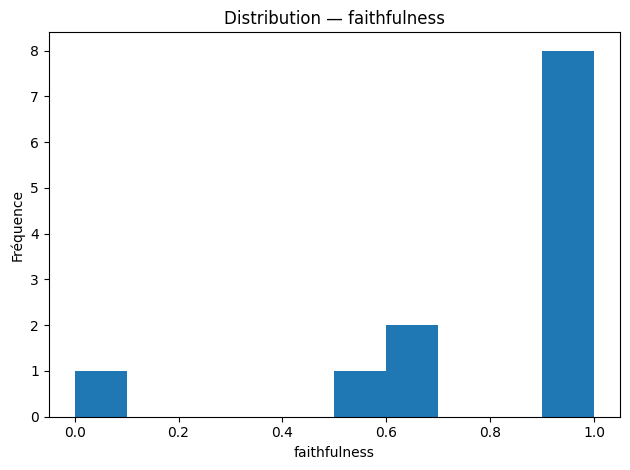

Saved: outputs/hist_answer_correctness.png


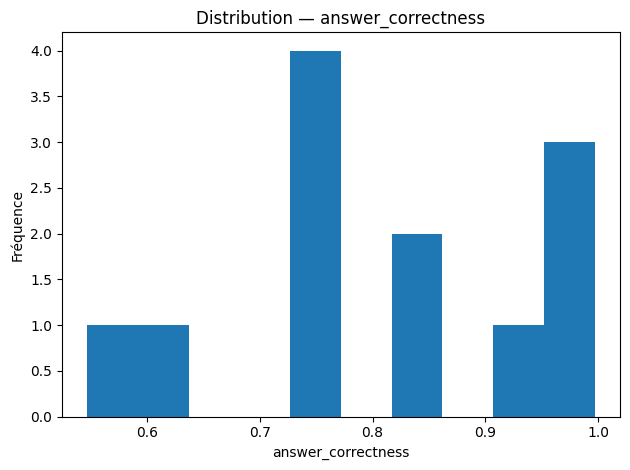

Saved: outputs/hist_answer_relevancy.png


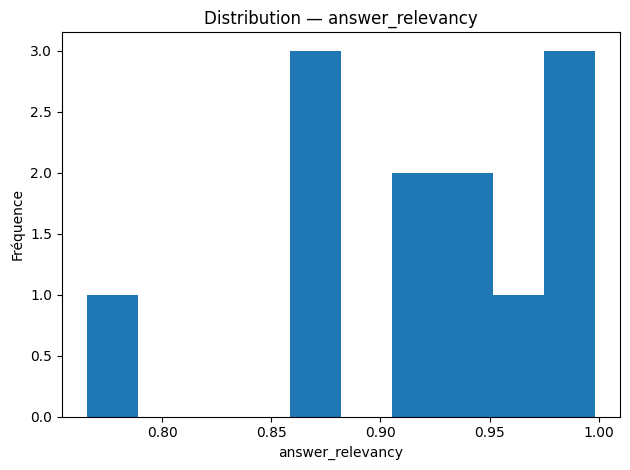

Saved: outputs/hist_context_precision.png


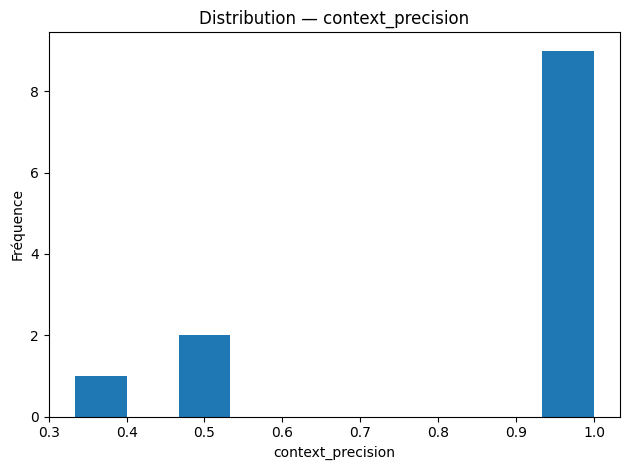

Saved: outputs/hist_context_recall.png


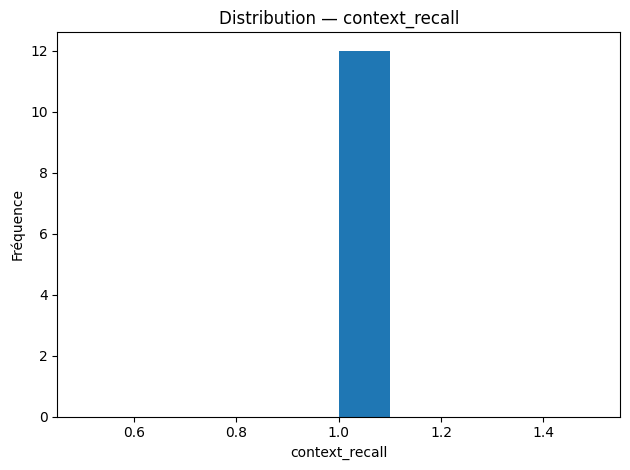

In [11]:

import matplotlib.pyplot as plt

rel_col = "response_relevancy" if "response_relevancy" in df_all.columns else ("answer_relevancy" if "answer_relevancy" in df_all.columns else None)
score_cols = ["faithfulness","answer_correctness","context_precision","context_recall"]
if rel_col:
    score_cols.insert(2, rel_col)

for col in score_cols:
    if col in df_all.columns:
        plt.figure()
        df_all[col].dropna().plot(kind="hist", bins=10, title=f"Distribution — {col}")
        plt.xlabel(col)
        plt.ylabel("Fréquence")
        plt.tight_layout()
        png = os.path.join(OUTPUT_DIR, f"hist_{col}.png")
        plt.savefig(png)
        print("Saved:", png)
        plt.show()



## 13) Focus erreurs — Top-K items les plus faibles

On liste les questions les moins bien notées pour faciliter le **debug ciblé**.


In [12]:

import pandas as pd

def topk_worst(col, k=15):
    if col not in df_all.columns:
        return pd.DataFrame()
    sub = df_all[["question","answer","ground_truth", col]].copy()
    sub = sub.sort_values(col, ascending=True).head(k)
    return sub

print("### Pires 'answer_correctness'")
display(topk_worst("answer_correctness"))

print("\n### Pires 'faithfulness'")
display(topk_worst("faithfulness"))

if rel_col:
    print(f"\n### Pires '{rel_col}'")
    display(topk_worst(rel_col))


### Pires 'answer_correctness'


,question,answer,ground_truth,answer_correctness
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.546984
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,0.621241
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,0.741270
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,0.743916
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.745691
11,De quel projet stratégique fait partie le Proj...,Le Projet Néo s'inscrit dans le cadre de l'ini...,Le Projet Néo est une composante clé de l'init...,0.747059
10,Quel risque a souligné David Chen concernant l...,David Chen a identifié un risque majeur concer...,David Chen a souligné un risque concernant la ...,0.834138
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.843853
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",0.907657
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,0.995710



### Pires 'faithfulness'


,question,answer,ground_truth,faithfulness
10,Quel risque a souligné David Chen concernant l...,David Chen a identifié un risque majeur concer...,David Chen a souligné un risque concernant la ...,0.000000
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.500000
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.666667
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.666667
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",1.000000
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,1.000000
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,1.000000
0,Qui est le chef de projet du Projet Néo ?,Marc Dubois est le chef de projet du Projet Né...,Marc Dubois est le chef de projet du Projet Néo.,1.000000
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,1.000000
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,1.000000



### Pires 'answer_relevancy'


,question,answer,ground_truth,answer_relevancy
7,Qui dirige l'équipe Data Warehouse ?,Hélène Petit occupe le poste de Directrice Dat...,Hélène Petit dirige l'équipe Data Warehouse.,0.765512
8,Quelle base de données est envisagée pour le p...,Neo4j est la base de données envisagée pour le...,Neo4j est envisagé comme base de données pour ...,0.869031
11,De quel projet stratégique fait partie le Proj...,Le Projet Néo s'inscrit dans le cadre de l'ini...,Le Projet Néo est une composante clé de l'init...,0.876977
3,Quelles sont les compétences de David Chen ?,"David Chen, Data Scientist Principal, maîtrise...","David Chen possède des compétences en Python, ...",0.881353
4,Qui est le manager de Sophie Martin ?,Marc Dubois est le manager de Sophie Martin se...,Marc Dubois est le manager de Sophie Martin.,0.920592
5,Quelle est la date limite pour le premier PoC ...,Sophie Martin doit livrer un premier PoC (Proo...,Sophie Martin doit livrer un premier PoC (Proo...,0.920652
2,Qui est le lead developer assigné au projet ?,Sophie Martin est désignée comme Lead Develope...,Sophie Martin est le lead developer assigné au...,0.930798
10,Quel risque a souligné David Chen concernant l...,David Chen a identifié un risque majeur concer...,David Chen a souligné un risque concernant la ...,0.942503
6,Quel framework a été confirmé pour le modèle p...,TensorFlow a été confirmé comme framework pour...,TensorFlow a été confirmé comme framework pour...,0.967857
1,Quel est l'objectif principal du Projet Néo ?,L'objectif du Projet Néo est de développer un ...,Le Projet Néo vise à développer un nouvel algo...,0.985759



## 14) Scatter diagnostics — relations entre métriques

Quelques nuages de points pour repérer des **patterns** (hallucinations, manque de rappel, etc.).


Saved: outputs/scatter_faithfulness_vs_answer_correctness.png


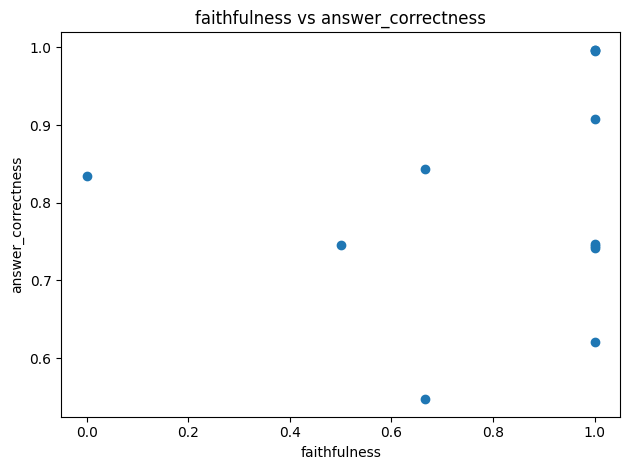

Saved: outputs/scatter_answer_relevancy_vs_answer_correctness.png


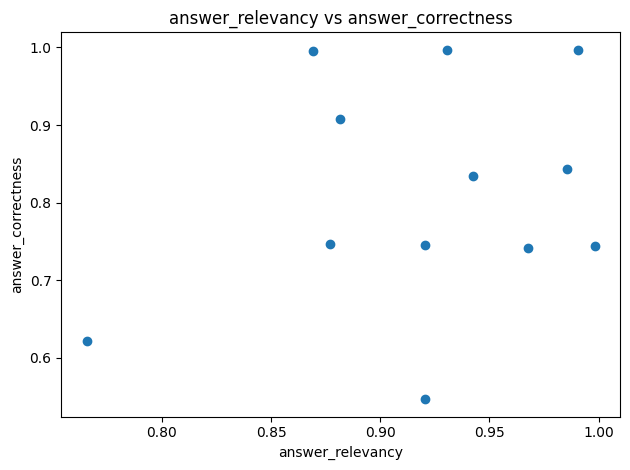

Saved: outputs/scatter_context_precision_vs_context_recall.png


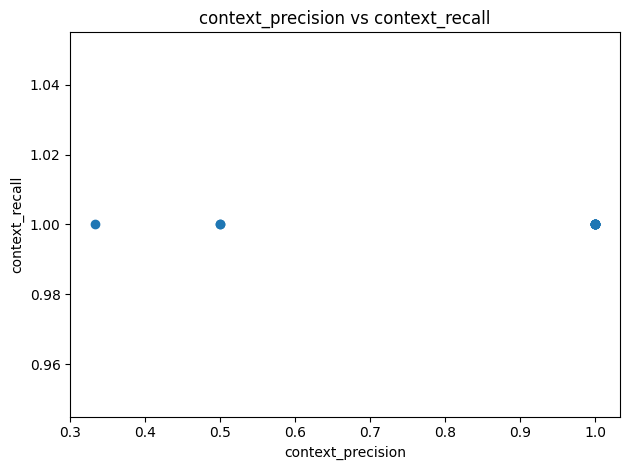

Saved: outputs/scatter_n_contexts_vs_answer_correctness.png


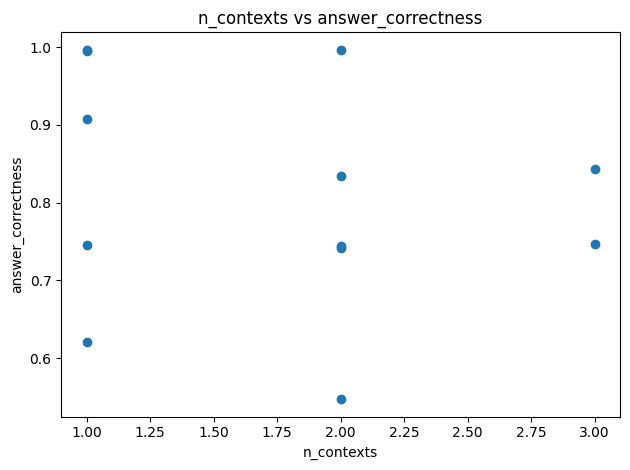

Saved: outputs/scatter_avg_context_len_vs_answer_correctness.png


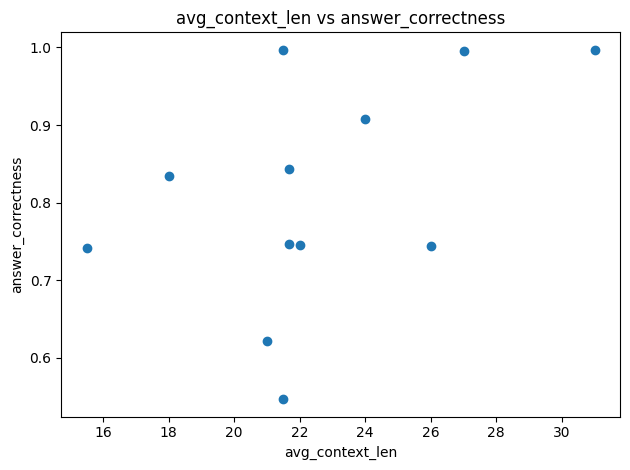

Saved: outputs/scatter_context_coverage_jaccard_vs_answer_correctness.png


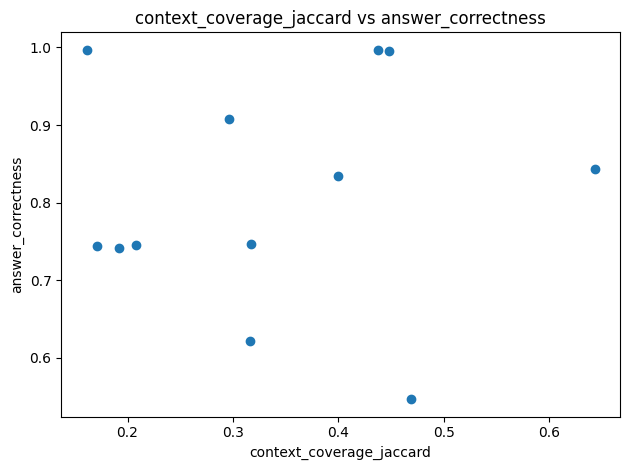

Saved: outputs/scatter_answer_coverage_jaccard_vs_answer_correctness.png


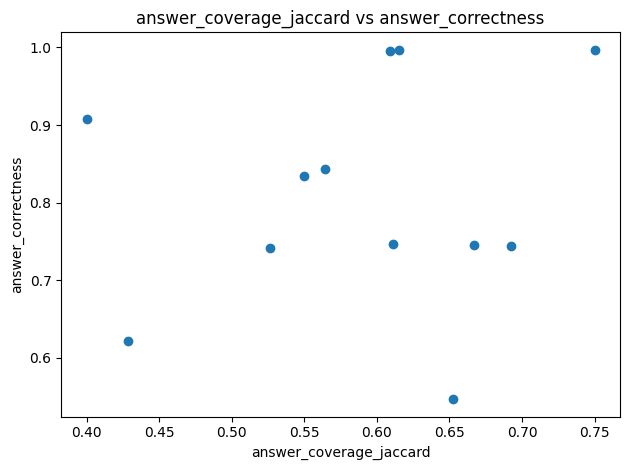

In [13]:

import matplotlib.pyplot as plt
import os

def scatter_xy(x, y):
    if x in df_all.columns and y in df_all.columns:
        plt.figure()
        plt.scatter(df_all[x], df_all[y])
        plt.xlabel(x); plt.ylabel(y)
        plt.title(f"{x} vs {y}")
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, f"scatter_{x}_vs_{y}.png")
        plt.savefig(outp)
        print("Saved:", outp)
        plt.show()

scatter_xy("faithfulness", "answer_correctness")
if rel_col:
    scatter_xy(rel_col, "answer_correctness")
scatter_xy("context_precision", "context_recall")
scatter_xy("n_contexts", "answer_correctness")
scatter_xy("avg_context_len", "answer_correctness")
scatter_xy("context_coverage_jaccard", "answer_correctness")
scatter_xy("answer_coverage_jaccard", "answer_correctness")



## 15) Corrélations — matrice

On calcule une corrélation simple (Pearson) entre variables numériques pour **prioriser les leviers**.


Saved: outputs/corr_matrix.png


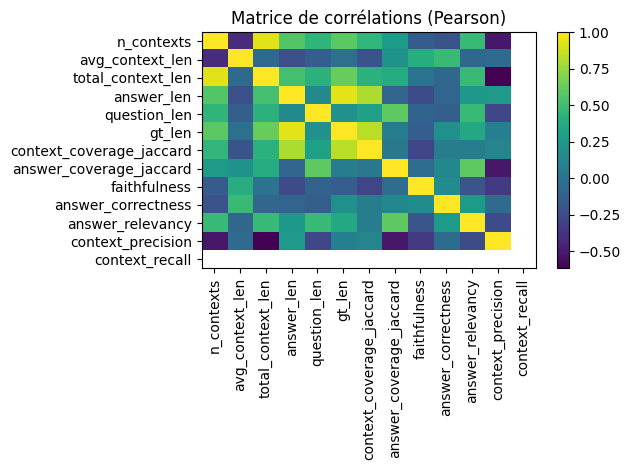

,answer_correctness
answer_correctness,1.000000
avg_context_len,0.475252
answer_relevancy,0.261566
gt_len,0.194047
faithfulness,0.166961
answer_coverage_jaccard,0.139931
context_coverage_jaccard,0.060692
context_precision,-0.044493
total_context_len,-0.084921
answer_len,-0.088770


In [14]:

import numpy as np
import matplotlib.pyplot as plt

num_cols = df_all.select_dtypes(include=[np.number]).columns.tolist()
corr = df_all[num_cols].corr()

plt.figure()
plt.imshow(corr, aspect='auto')
plt.xticks(range(len(num_cols)), num_cols, rotation=90)
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()
plt.title("Matrice de corrélations (Pearson)")
plt.tight_layout()
png = os.path.join(OUTPUT_DIR, "corr_matrix.png")
plt.savefig(png)
print("Saved:", png)
plt.show()

# Affiche les 10 variables les + corrélées à answer_correctness si présente
if "answer_correctness" in corr.columns:
    display(corr.sort_values(by="answer_correctness", ascending=False)[["answer_correctness"]].head(10))



## 16) Effet du nombre de contextes — agrégations par bin

On observe comment les scores évoluent selon **`n_contexts`** (peut orienter le **cutoff top-k**, le **reranking**, etc.).


/tmp/ipykernel_9278/4114247817.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_all.groupby(b)[metrics_cols].mean(numeric_only=True)


,n_contexts,faithfulness,answer_correctness,context_precision,context_recall,answer_relevancy
0,"(0, 1]",0.900000,0.853392,1.000000,1.0,0.873457
1,"(1, 2]",0.733333,0.772649,0.800000,1.0,0.963993
2,"(2, 3]",0.833333,0.795456,0.666667,1.0,0.931368
3,"(3, 4]",NaN,NaN,NaN,NaN,NaN
4,"(4, 6]",NaN,NaN,NaN,NaN,NaN
5,"(6, 10]",NaN,NaN,NaN,NaN,NaN
6,"(10, 999]",NaN,NaN,NaN,NaN,NaN


Saved: outputs/bar_faithfulness_by_ncontexts_bins.png


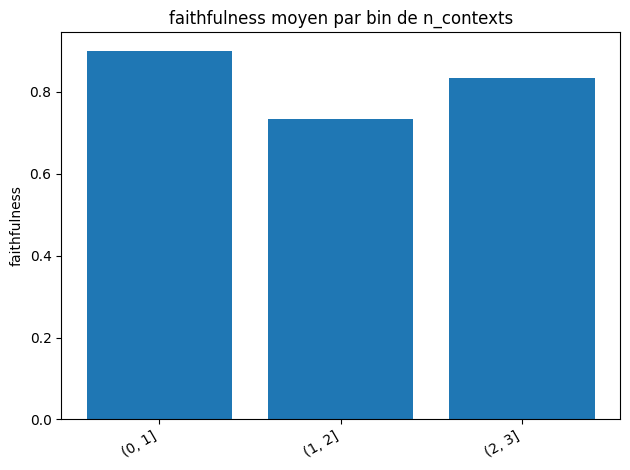

Saved: outputs/bar_answer_correctness_by_ncontexts_bins.png


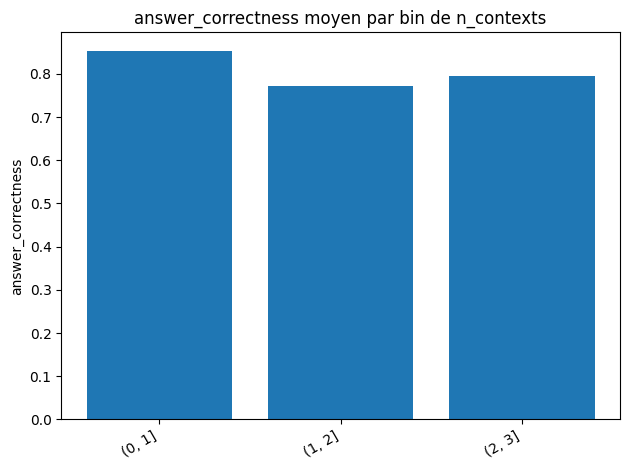

Saved: outputs/bar_context_precision_by_ncontexts_bins.png


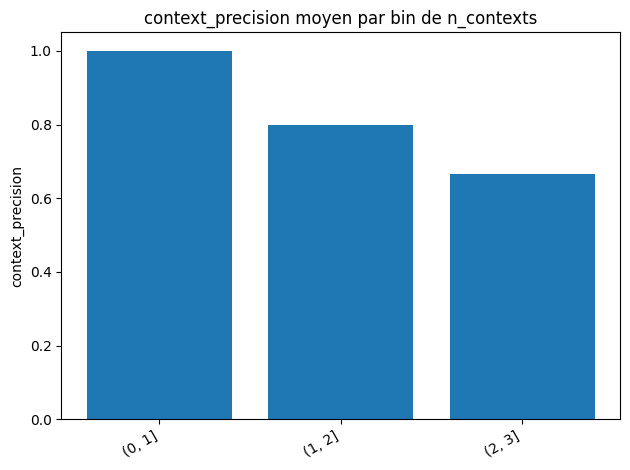

Saved: outputs/bar_context_recall_by_ncontexts_bins.png


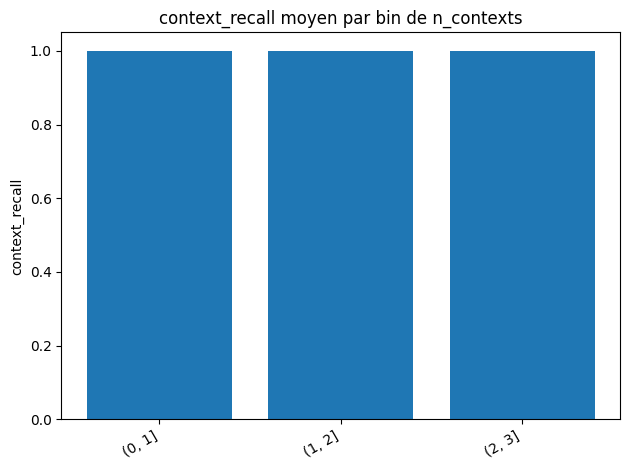

Saved: outputs/bar_answer_relevancy_by_ncontexts_bins.png


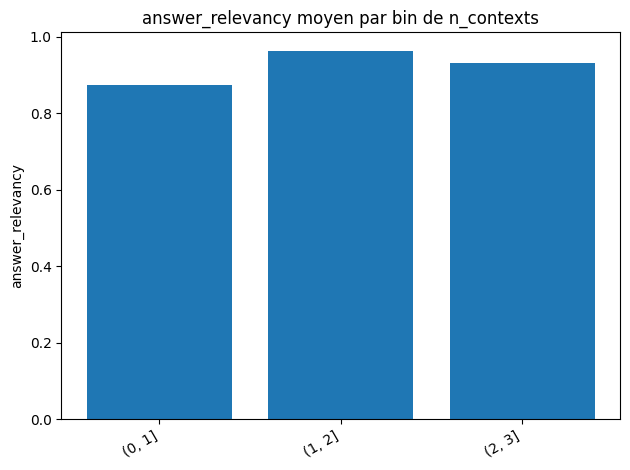

In [15]:

import pandas as pd
import matplotlib.pyplot as plt

def agg_by_bins(col, bins=(0,1,2,3,4,6,10,999)):
    if col not in df_all.columns:
        return pd.DataFrame()
    b = pd.cut(df_all[col], bins=bins, right=True)
    metrics_cols = ["faithfulness","answer_correctness","context_precision","context_recall"]
    if rel_col and rel_col in df_all.columns:
        metrics_cols = metrics_cols + [rel_col]
    agg = df_all.groupby(b)[metrics_cols].mean(numeric_only=True)
    return agg.reset_index()

agg_ctx = agg_by_bins("n_contexts")
display(agg_ctx)

# Bar charts (une figure par métrique)
plot_cols = ["faithfulness","answer_correctness","context_precision","context_recall"]
if rel_col:
    plot_cols.append(rel_col)

for c in plot_cols:
    if c in agg_ctx.columns:
        plt.figure()
        x = agg_ctx.iloc[:,0].astype(str)
        y = agg_ctx[c]
        plt.bar(x, y)
        plt.xticks(rotation=30, ha="right")
        plt.ylabel(c)
        plt.title(f"{c} moyen par bin de n_contexts")
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, f"bar_{c}_by_ncontexts_bins.png")
        plt.savefig(outp)
        print("Saved:", outp)
        plt.show()



## 17) Analyse par document/source (facultatif)

Si votre CSV inclut une colonne source (ex. `sharepoint_document`), on peut agréger les performances par document.


,faithfulness,answer_correctness,context_precision,context_recall,answer_relevancy
sharepoint_document,,,,,
Note de cadrage - Projet Neo.txt,0.933333,0.865439,0.766667,1.0,0.932150
Compte-Rendu de Reunion.txt,0.666667,0.779832,0.875000,1.0,0.955445
Repertoire equipe - Projet Neo.txt,0.833333,0.758196,1.000000,1.0,0.855819


Saved: outputs/bar_top_docs_answer_correctness.png


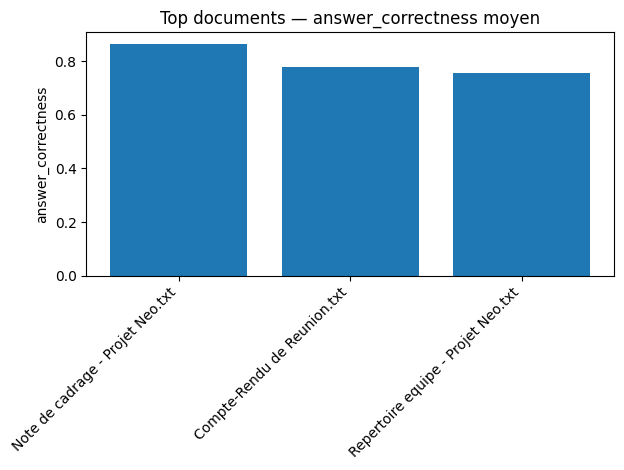

In [16]:

import pandas as pd
import matplotlib.pyplot as plt

src_col_candidates = ["sharepoint_document","source","doc","document"]
src_col = None
for c in src_col_candidates:
    if c in raw_df.columns:
        src_col = c
        break

if src_col:
    # Assemble per-source frame
    metric_cols = ["faithfulness","answer_correctness","context_precision","context_recall"]
    if rel_col and rel_col in df_all.columns:
        metric_cols.append(rel_col)
    per_src = pd.concat([raw_df[[src_col]], df_all[metric_cols]], axis=1)
    agg_src = per_src.groupby(src_col).mean(numeric_only=True).sort_values("answer_correctness", ascending=False)
    display(agg_src.head(10))

    # Top docs bar
    topk = agg_src.head(10)
    if len(topk) > 0:
        plt.figure()
        plt.bar(topk.index.astype(str), topk["answer_correctness"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("answer_correctness")
        plt.title("Top documents — answer_correctness moyen")
        plt.tight_layout()
        outp = os.path.join(OUTPUT_DIR, "bar_top_docs_answer_correctness.png")
        plt.savefig(outp)
        print("Saved:", outp)
        plt.show()
else:
    print("Aucune colonne source détectée parmi", src_col_candidates)



## 18) Recommandations automatiques (générées à partir des signaux)

Pistes d’optimisation :
- **Préprocessing PDF** : OCR, nettoyages, normalisation espaces, en-têtes/pieds, tableaux.
- **Embeddings** : modèle/dimension adaptés au domaine/langue; normalisation; stopwords.
- **Chunking** : taille (512–800 tokens) & overlap; **découpe sémantique** via titres/sections; tables/code séparés.
- **Recherche** : **hybride** (BM25 + vecteur), pondération; filtres métadonnées; top-k équilibré.
- **Reranking** : Cross-encoder / LLM-as-a-reranker; réduction à 3–5 passages.
- **Génération** : prompts de **citation stricte**, température basse; self-check.


In [17]:

import os

reco = []

def add(msg):
    print("•", msg)
    reco.append("• " + msg)

# Heuristiques basées sur df_all
if "faithfulness" in df_all and df_all["faithfulness"].mean() < 0.6:
    add("Fidélité basse : renforcer les **citations** de contexte, réduire la créativité (temp=0), et utiliser des consignes d'extraction stricte.")

if "answer_correctness" in df_all and df_all["answer_correctness"].mean() < 0.6:
    add("Correction faible : améliorer **instructions de génération** (format, champs obligatoires), et ajouter une **post-vérification LLM** (self-consistency).")

if "context_recall" in df_all and df_all["context_recall"].mean() < 0.6:
    add("Rappel faible : augmenter **top-k**, activer la **recherche hybride** (BM25+vecteur), améliorer **chunking** & **préprocessing PDF**.")

if "context_precision" in df_all and df_all["context_precision"].mean() < 0.6:
    add("Précision faible : activer un **reranker** (cross-encoder), baisser **top-k** avant génération, affiner filtres métadonnées.")

if "n_contexts" in df_all and "answer_correctness" in df_all and df_all["n_contexts"].corr(df_all["answer_correctness"]) < -0.15:
    add("Trop de contextes nuit à la correction : **réduire top-k** ou reranker plus agressivement.")

if "context_coverage_jaccard" in df_all and df_all["context_coverage_jaccard"].mean() < 0.4:
    add("Recouvrement GT↔Contexts faible : vérifier **extraction PDF/OCR**, embeddings adaptés, **chunking** par sections/titres.")

print("=== Recommandations automatiques ===")
for r in reco:
    print(r)

# Sauvegarde
txt_out = os.path.join(OUTPUT_DIR, "auto_recommendations.txt")
with open(txt_out, "w", encoding="utf-8") as f:
    f.write("Recommandations automatiques\n\n")
    for r in reco:
        f.write(r + "\n")
print("Recommandations ->", txt_out)


• Trop de contextes nuit à la correction : **réduire top-k** ou reranker plus agressivement.
• Recouvrement GT↔Contexts faible : vérifier **extraction PDF/OCR**, embeddings adaptés, **chunking** par sections/titres.
=== Recommandations automatiques ===
• Trop de contextes nuit à la correction : **réduire top-k** ou reranker plus agressivement.
• Recouvrement GT↔Contexts faible : vérifier **extraction PDF/OCR**, embeddings adaptés, **chunking** par sections/titres.
Recommandations -> outputs/auto_recommendations.txt



## 19) Plan d’expériences (A/B & grid)

Génère un **plan d’expériences** pour itérer systématiquement :
- **Préprocessing** : extraction (pdfminer/pymupdf), OCR (tesseract), nettoyage en-têtes/pieds
- **Embeddings** : modèle/dim/normalisation
- **Chunking** : taille/overlap/sémantique
- **Recherche** : vecteur/hybride, top-k
- **Reranking** : modèle, top-k


In [18]:

import json, os

param_grid = {
    "preprocess": [
        {"ocr": False, "clean_headers": True, "normalize_ws": True},
        {"ocr": True,  "clean_headers": True, "normalize_ws": True},
    ],
    "embedding": [
        {"provider":"openai","model":"text-embedding-3-large"},
        {"provider":"openai","model":"text-embedding-3-small"},
        {"provider":"nomic","model":"nomic-embed-text"},
    ],
    "chunking": [
        {"method":"fixed","size":512,"overlap":64},
        {"method":"fixed","size":800,"overlap":100},
        {"method":"semantic","size":"auto","overlap":64},
    ],
    "retrieval": [
        {"type":"vector","top_k":8},
        {"type":"hybrid","bm25_weight":0.4,"top_k":8},
        {"type":"hybrid","bm25_weight":0.6,"top_k":12},
    ],
    "rerank": [
        {"enabled": False},
        {"enabled": True, "model":"cross-encoder/ms-marco-MiniLM-L-6-v2", "top_k":5},
    ],
}

print(json.dumps(param_grid, indent=2, ensure_ascii=False))
grid_out = os.path.join(OUTPUT_DIR, "experiment_plan.json")
with open(grid_out, "w", encoding="utf-8") as f:
    json.dump(param_grid, f, ensure_ascii=False, indent=2)
print("Plan d'expériences ->", grid_out)


{
  "preprocess": [
    {
      "ocr": false,
      "clean_headers": true,
      "normalize_ws": true
    },
    {
      "ocr": true,
      "clean_headers": true,
      "normalize_ws": true
    }
  ],
  "embedding": [
    {
      "provider": "openai",
      "model": "text-embedding-3-large"
    },
    {
      "provider": "openai",
      "model": "text-embedding-3-small"
    },
    {
      "provider": "nomic",
      "model": "nomic-embed-text"
    }
  ],
  "chunking": [
    {
      "method": "fixed",
      "size": 512,
      "overlap": 64
    },
    {
      "method": "fixed",
      "size": 800,
      "overlap": 100
    },
    {
      "method": "semantic",
      "size": "auto",
      "overlap": 64
    }
  ],
  "retrieval": [
    {
      "type": "vector",
      "top_k": 8
    },
    {
      "type": "hybrid",
      "bm25_weight": 0.4,
      "top_k": 8
    },
    {
      "type": "hybrid",
      "bm25_weight": 0.6,
      "top_k": 12
    }
  ],
  "rerank": [
    {
      "enabled": false
    }


## 20) Checklist d’optimisation RAG (rapide)

- **PDF** : extraction fiable (texte non perdu), OCR si scans, suppression artefacts (numéros de page, headers/footers).
- **Embeddings** : modèle adapté domaine/langue; normalisation; taille de vecteur suffisante; casing/stopwords.
- **Chunking** : cohérent avec la structure (titres/sections), taille modérée (512–800 tokens) + overlap; séparation tableaux/code.
- **Index** : stockage des métadonnées (titre, section, date, doc_id) pour filtrage.
- **Retrieval** : tester **hybride** (BM25 + vecteur), pondération; filtrage par métadonnées; top-k équilibré.
- **Reranking** : cross-encoder/LLM-as-reranker; réduire à 3–5 passages de plus haute qualité.
- **Génération** : prompt d’extraction contrôlée (citations obligatoires), température basse, JSON strict; self-check.
- **Évaluation** : référentiels métier à jour; seuils de GO/NO-GO; journaliser la config de run.
